In [1]:
# doc https://mp.weixin.qq.com/s/Pq3WO3M6tnvvwWXoJ7XYDA
# reference https://github.com/piyush-hurkat/3D-CNN-for-action-recognition
# dataset https://www.csc.kth.se/cvap/actions/
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split,cross_validate
from sklearn import preprocessing
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import SGD,RMSprop
import theano
from tensorflow.keras import Input,Model
from tensorflow.keras.layers import Dense,Flatten,Conv3D,MaxPooling3D,Dropout,BatchNormalization,concatenate,Activation
from tensorflow.keras.utils import to_categorical
import h5py
import tensorflow.keras.backend as tfback
import keras

tf.keras.backend.set_image_data_format('channels_first')


In [2]:
tf.__version__, keras.__version__

('2.8.0', '2.8.0')

In [3]:
path = "/content/dataset/kth"
os.listdir(path)

['handwaving',
 'running.zip',
 'boxing.zip',
 'handclapping.zip',
 'boxing',
 'jogging.zip',
 'walking.zip',
 'running',
 'handclapping',
 'handwaving.zip',
 'walking',
 'jogging']

In [4]:
# image specification
img_rows,img_cols,img_depth=80,60,9
# Training data
X_tr=[]           # variable to store entire dataset

In [5]:
folders = os.listdir(path)
for folder in folders:
  if 'zip' not in folder:
    filepath = os.path.join(path, folder)
    files = os.listdir(filepath)
    print(len(files))

100
100
100
99
100
100


In [6]:
path = "/content/dataset/kth"
folders = os.listdir(path)
for folder in folders:
  if 'zip' not in folder:
    filepath = os.path.join(path, folder)
    files = os.listdir(filepath)
    for file in files:
      vid = os.path.join(path, folder, file)
      frames1 = []
      frames2 = []
      frames3 = []
      optflow = np.zeros((img_depth-1, img_rows, img_cols, 2))
      optflow_x = np.zeros((img_depth-1, img_rows, img_cols, 2))
      optflow_y = np.zeros((img_depth-1, img_rows, img_cols, 2))
      cap = cv2.VideoCapture(vid)
      fps = cap.get(5)
      # print ("Frames per second using video.get(cv2.cv.CV_CAP_PROP_FPS): {0}".format(fps))
      for k in range(img_depth):
          ret, frame = cap.read()
          frame=cv2.resize(frame,(img_rows,img_cols),interpolation=cv2.INTER_AREA)
          gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
          gradient_x = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=5)
          gradient_y = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=5)
          if k+1<img_depth:
            optflow[k] = cv2.calcOpticalFlowFarneback(gray[k],gray[k+1], None, 0.5, 3, 15, 3, 5, 1.2, 0)
          
          frames1.append(gray)
          frames2.append(gradient_x)
          frames3.append(gradient_y)
          # plt.imshow(gray, cmap = plt.get_cmap('gray'))
          # plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
          # plt.show()
          # cv2.imshow('frame',gray)
        

          if cv2.waitKey(1) & 0xFF == ord('q'):
              break
      cap.release()
      cv2.destroyAllWindows()
      
      optflow_x = cv2.normalize(optflow[...,0], None, 0, 255, cv2.NORM_MINMAX) 
      optflow_x = optflow_x.astype('uint8')  
      optflow_y = cv2.normalize(optflow[...,1], None, 0, 255, cv2.NORM_MINMAX)
      optflow_y = optflow_y.astype('uint8')
      f1=np.array(frames1)
      f2=np.array(frames2)
      f3=np.array(frames3)
      f4=np.array(optflow_x)
      f5=np.array(optflow_y)
      f4=np.reshape(f4,(img_depth-1,img_cols,img_rows))
      f5=np.reshape(f5,(img_depth-1,img_cols,img_rows))

      concat=np.concatenate((f1,f2,f3,f4,f5))
      input=np.array(concat)
      # print (input.shape)
      ipt=np.rollaxis(np.rollaxis(input,2,0),2,0)
      # print (ipt.shape)

      X_tr.append(ipt)

print(len(X_tr))


599


In [7]:
X_tr_array = np.array(X_tr) # convert the frames read into array
X_tr_array = np.reshape(X_tr_array,(599,80,60,43))
X_tr_array.shape

(599, 80, 60, 43)

In [8]:
#Assign Label to each class
num_samples = len(X_tr_array)
label=np.ones((num_samples,),dtype = int)
label[0:100]= 0
label[100:200] = 1
label[200:300] = 2
label[300:400] = 3
label[400:499]= 4
label[499:] = 5

In [9]:
# 创建数据集
train_data = [X_tr_array,label]
(X_train, y_train) = (train_data[0],train_data[1])
print('X_Train shape:', X_train.shape)

train_set = np.zeros((num_samples, 1, img_rows,img_cols,43)) # 定义单通道

for h in range(num_samples):
  train_set[h][0][:][:][:]=X_train[h,:,:,:]
 

patch_size = 43    # img_depth or number of frames used for each video

print(train_set.shape, 'train samples')

# CNN Training parameters

batch_size = 2
nb_classes =6 
nb_epoch =50

# convert class vectors to binary class matrices
Y_train = to_categorical(y_train, nb_classes)

'''
# number of convolutional filters to use at each layer
nb_filters = [32, 32]

# level of pooling to perform at each layer (POOL x POOL)
nb_pool = [3, 3]

# level of convolution to perform at each layer (CONV x CONV)
nb_conv = [5,5]
'''
# Pre-processing

train_set = train_set.astype('float32')

train_set -= np.mean(train_set)

train_set /=np.max(train_set)


X_Train shape: (599, 80, 60, 43)
(599, 1, 80, 60, 43) train samples


In [10]:
def _get_available_gpus():
    """Get a list of available gpu devices (formatted as strings).

    # Returns
        A list of available GPU devices.
    """
    #global _LOCAL_DEVICES

    devices = tf.config.list_logical_devices()
    tfback._LOCAL_DEVICES = [x.name for x in devices]
    return [x for x in tfback._LOCAL_DEVICES if 'device:gpu' in x.lower()]


In [11]:
tfback._get_available_gpus = _get_available_gpus
tfback._get_available_gpus()

['/device:GPU:0']

In [12]:
tf.config.list_logical_devices()

[LogicalDevice(name='/device:CPU:0', device_type='CPU'),
 LogicalDevice(name='/device:GPU:0', device_type='GPU')]

In [13]:
# Define model

model = Sequential()

model.add(Conv3D(8, (9, 7, 3),input_shape=(1, img_rows, img_cols, 43), activation='relu'))
model.add(MaxPooling3D(pool_size=(3, 3, 1)))
model.add(BatchNormalization(center=True, scale=True))
model.add(Dropout(0.5))

model.add(Conv3D(16, (7, 7, 3),input_shape=(1, img_rows, img_cols, 43), activation='relu'))
model.add(MaxPooling3D(pool_size=(3, 3,1)))
model.add(BatchNormalization(center=True, scale=True))
model.add(Dropout(0.5))

model.add(Conv3D(32, (6, 4, 1),input_shape=(1, img_rows, img_cols, 43), activation='relu'))
model.add(BatchNormalization(center=True, scale=True))
model.add(Dropout(0.5))
model.add(Flatten())
#model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(nb_classes, kernel_initializer='normal'))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])


In [14]:
#model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])

# Split the data

X_train_new, X_val_new, y_train_new,y_val_new =  train_test_split(train_set, Y_train, test_size=0.2, random_state=4)



In [15]:
hist = model.fit(X_train_new, y_train_new, validation_data=(X_val_new,y_val_new),batch_size=batch_size,epochs = nb_epoch,shuffle=True)

Epoch 1/50
240/240 [==============================] - 21s 40ms/step - loss: 2.6364 - accuracy: 0.3069 - val_loss: 1.6715 - val_accuracy: 0.3083
Epoch 2/50
240/240 [==============================] - 9s 38ms/step - loss: 1.9638 - accuracy: 0.4301 - val_loss: 1.0484 - val_accuracy: 0.4583
Epoch 3/50
240/240 [==============================] - 9s 38ms/step - loss: 1.7775 - accuracy: 0.4489 - val_loss: 1.3015 - val_accuracy: 0.5500
Epoch 4/50
240/240 [==============================] - 9s 37ms/step - loss: 1.6467 - accuracy: 0.4614 - val_loss: 1.1980 - val_accuracy: 0.4667
Epoch 5/50
240/240 [==============================] - 9s 38ms/step - loss: 1.4652 - accuracy: 0.5073 - val_loss: 1.1564 - val_accuracy: 0.4833
Epoch 6/50
240/240 [==============================] - 9s 37ms/step - loss: 1.2638 - accuracy: 0.5240 - val_loss: 0.9242 - val_accuracy: 0.6167
Epoch 7/50
240/240 [==============================] - 9s 39ms/step - loss: 1.2080 - accuracy: 0.5136 - val_loss: 1.2014 - val_accuracy: 0.525

60/60 [==============================] - 1s 16ms/step - loss: 1.6404 - accuracy: 0.7083
Test score: 1.640383005142212
Test accuracy: 0.7083333134651184
['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


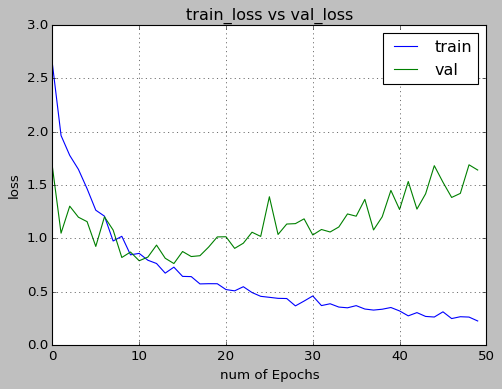

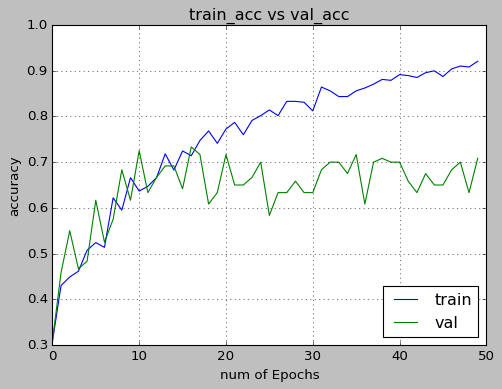

In [17]:



#hist = model.fit(train_set, Y_train, batch_size=batch_size,
#         nb_epoch=nb_epoch,validation_split=0.2, show_accuracy=True,
#           shuffle=True)
#batch_size=32
#nb_epoch=120
 # Evaluate the model
score = model.evaluate(X_val_new, y_val_new, batch_size=batch_size)
print('Test score:', score[0])
print('Test accuracy:', score[1])


# Plot the results
train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['accuracy']
val_acc=hist.history['val_accuracy']
xc=range(nb_epoch)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
print (plt.style.available) # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic']) 